In [1]:
import sys

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

sys.path.append("/home/aseliverstov/projects/brain_signals/experiments/src")
from src.dataset import EEG
from src.features import calculate_summary_features
from src.augmentations import augment_timeseries

2025-02-02 02:07:37.076301: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-02 02:07:37.196100: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-02 02:07:37.338843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738451257.544598  214905 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738451257.611207  214905 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 02:07:37.808828: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
data_dir = Path("/home/aseliverstov/projects/brain_signals/dataset")
intencities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
n_channels = 31

mona_dataset = EEG(data_dir=data_dir, intencities=intencities, n_channels=n_channels, image_name="Figs for spectra")
cube_dataset = EEG(data_dir=data_dir, intencities=intencities, n_channels=n_channels, image_name="Cubes for spectra")

mona_dataset.load_to_dataframe(users=[1], signals=["delta"])
cube_dataset.load_to_dataframe(users=[1], signals=["delta"])

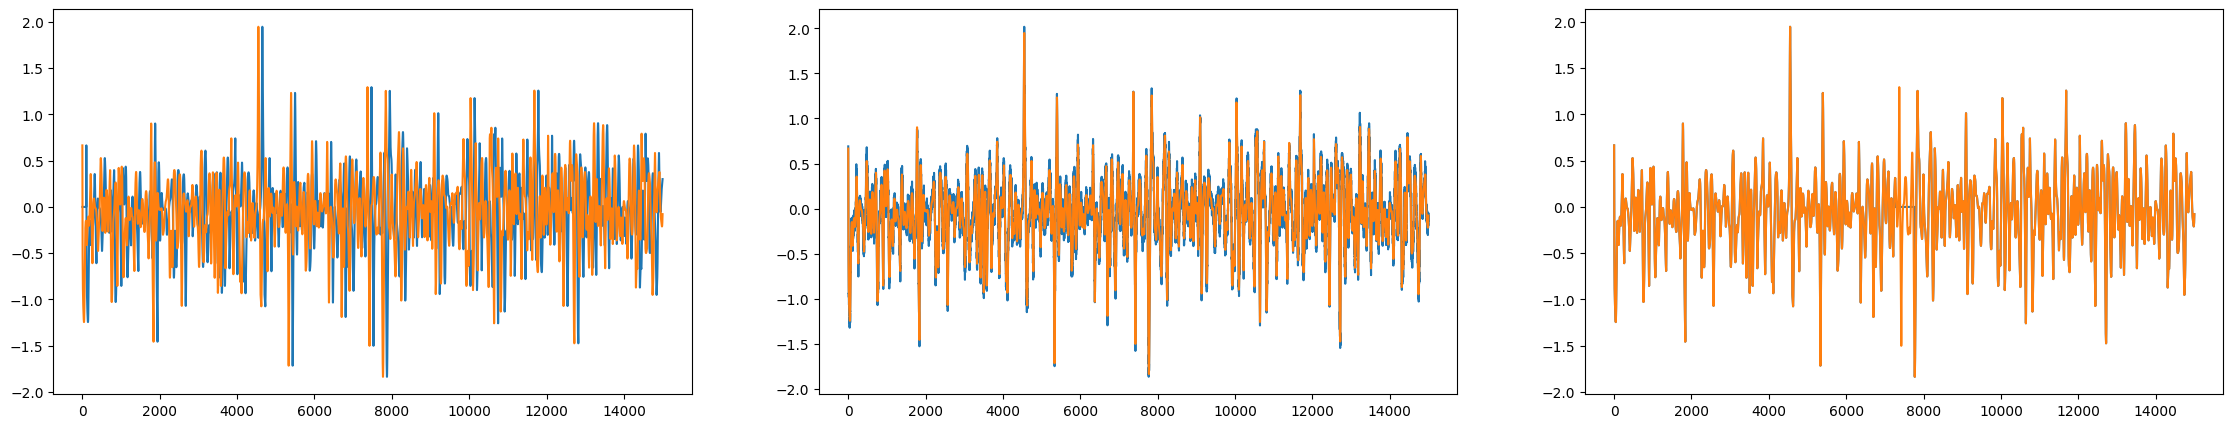

In [3]:
import matplotlib.pyplot as plt

X_train, y_train = mona_dataset.X, mona_dataset.y
X_test, y_test = cube_dataset.X, cube_dataset.y

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ts_to_plot = augment_timeseries(
    X_train[0:1], y_train[0:1],
    num_shift=1, shift_params={'n_timestamps': 500, 'seed': 42},
    num_noise=1, noise_params={'noise_intensity': 0.05, 'seed': 42},
    num_mask=1, mask_params={'mask_length': 500, 'seed': 42}
)[0]

fig, ax = plt.subplots(1, 3, figsize=(28, 5))

for i in range(1, 4):
    ax[i - 1].plot(ts_to_plot[i])
    ax[i - 1].plot(ts_to_plot[0])


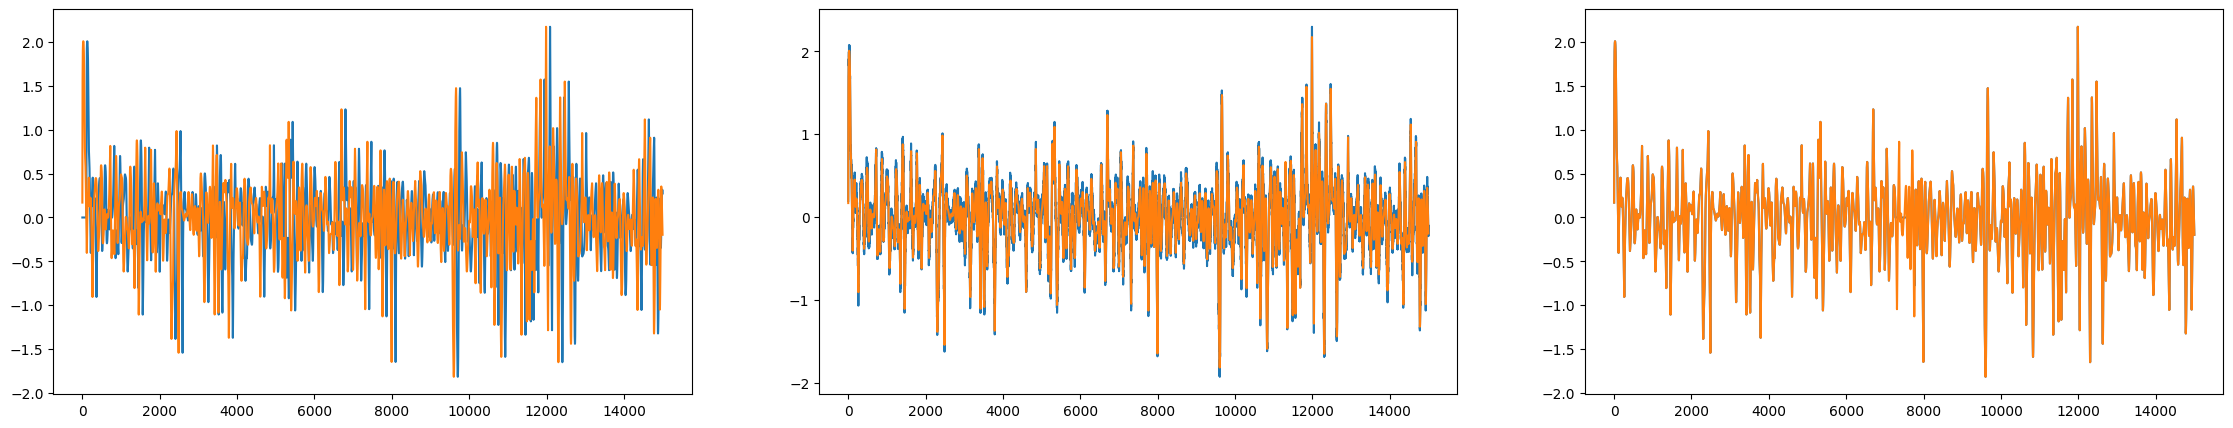

In [4]:
ts_to_plot = augment_timeseries(
    X_test[0:1], y_test[0:1],
    num_shift=1, shift_params={'n_timestamps': 500, 'seed': 42},
    num_noise=1, noise_params={'noise_intensity': 0.05, 'seed': 42},
    num_mask=1, mask_params={'mask_length': 500, 'seed': 42}
)[0]

fig, ax = plt.subplots(1, 3, figsize=(28, 5))

for i in range(1, 4):
    ax[i - 1].plot(ts_to_plot[i])
    ax[i - 1].plot(ts_to_plot[0])

# Model

In [5]:
X_train, y_train = mona_dataset.X, mona_dataset.y
X_test, y_test = cube_dataset.X, cube_dataset.y

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# X_train, y_train = augment_timeseries(
#     X_train, y_train,
#     num_shift=500, shift_params={'n_timestamps': 100, 'seed': 42},
#     num_noise=5000, noise_params={'noise_intensity': 0.05, 'seed': 42},
#     num_mask=500, mask_params={'mask_length': 100, 'seed': 42}
# )

X_train = calculate_summary_features(X_train, n_windows=50)
X_test = calculate_summary_features(X_test, n_windows=50)

X_train.shape

(310, 300)

In [11]:
model = Sequential()
model.add(Dense(64, input_shape= (X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=mse,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=16, verbose=1)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.5930 - val_loss: 0.2242
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2582 - val_loss: 0.1129
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1573 - val_loss: 0.0863
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0890 - val_loss: 0.0826
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0883 - val_loss: 0.0830
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0905 - val_loss: 0.0826
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0821 - val_loss: 0.0826
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0831 - val_loss: 0.0831
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0908 - val_loss: 0.0827
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0805 - val_loss: 0.0827


In [12]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,653 (272.09 KB)

 Trainable params: 23,217 (90.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,436 (181.39 KB)